In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo unzip "/content/drive/MyDrive/vos/train.zip" -d "/content/vos"

Streaming output truncated to the last 5000 lines.
  inflating: /content/vos/train/JPEGImages/7e24023274/00010.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00125.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00150.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00165.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00090.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00110.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00005.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00070.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00045.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00030.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00105.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00085.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00170.jpg  
  inflating: /content/vos/train/JPEGImages/7e24023274/00145.jpg  
  inflating: /content/vos

In [6]:
import torch

In [45]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 1
device

'cuda:0'

## Visualize Utils

In [275]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def visualize(image_path, anchor_boxes):

  image = Image.open(image_path)
  image = image.resize((800, 800))

  image = np.array(image)
  
  for i_box, box in enumerate(anchor_boxes):
    
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    
    cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
    
  plt.imshow(image)
  plt.show()

In [141]:
## UNIT TEST
# visualize("/content/0_15_hazy.png", anchor_boxes[20000:20100])

In [ ]:
def visualize_a_box(image_path, box):
  visualize(image_path, [box])

## Generate Anchor Boxes

In [46]:
import numpy as np

In [47]:
def gen_anchor_box_for_single_feature_map(center_X, center_Y, scales, ratios):
  
  # Anchor Boxes are generated in the format (x1, y1, x2, y2)
  
  k = 0
  boxes = np.zeros((len(scales) * len(ratios), 4))

  for ratio in ratios:
    
    for scale in scales:

      W = scale * subsample * ratio
      H = scale * subsample

      x_left_top = center_X - (1/2) * W
      y_left_top = center_Y - (1/2) * H

      x_right_bottom = center_X + (1/2) * W
      y_right_bottom = center_Y + (1/2) * H 

      boxes[k, 0] = x_left_top
      boxes[k, 1] = y_left_top
      boxes[k, 2] = x_right_bottom
      boxes[k, 3] = y_right_bottom

      k += 1

  return boxes


In [48]:
## UNIT TEST
# gen_anchor_box_for_single_feature_map(400, 400, [8, 16, 32], [0.5, 1, 2]) # output has to be in shape of (3 * 3, 4)

In [49]:
subsample = 16
scales = [8, 16, 32]
ratios = [0.5, 1, 2]

In [50]:
def generate_all_anchor_boxes():
  
  anchor_boxes = np.zeros((50, 50, len(scales) * len(ratios), 4)) 
  
  # center_X, center_Y
  for i, center_X in enumerate(np.arange(8, 16 * (50), 16 )):
    for j, center_Y in enumerate(np.arange(8, 16 * (50), 16)):
      anchor_boxes[i, j] = gen_anchor_box_for_single_feature_map(center_X, center_Y, scales, ratios)

  return anchor_boxes.reshape(-1, 4)

In [51]:
#anchor_boxes = generate_all_anchor_boxes()
#anchor_boxes.shape

### Valid anchors

In [52]:
def get_valid_anchor_boxes(anchor_boxes):
  # x1 and x2 have to in range (0, 800), same applies to y1, y2
  inside_anchors_index = (anchor_boxes[:, 0] >= 0) & (anchor_boxes[:, 2] < 800) &\
  (anchor_boxes[:, 1] >= 0) & (anchor_boxes[:, 3] < 800)

  # valid_anchor_boxes = anchor_boxes[inside_anchors_index]

  return inside_anchors_index

In [53]:
# UNIT TEST
# the exact number depends on the scales and ratios you used
# (inside_anchors_index == True).sum() > 0

## Compute IoU

In [54]:
def compute_iou(box1, box2):
  # assumeing boxes are in format (x1, y1, x2, y2)
  inter = {}
  inter["x_left_top"] = max(box1[0], box2[0])
  inter["y_left_top"] = max(box1[1], box2[1])

  inter["x_right_bottom"] = min(box1[2], box2[2])
  inter["y_right_bottom"] = min(box1[3], box2[3])

  if inter["x_left_top"] < inter["x_right_bottom"] and inter["y_left_top"] < inter["y_right_bottom"]: # there is a non-zero intersection  
    iou_area = (inter["x_right_bottom"] - inter["x_left_top"]) * (inter["y_right_bottom"] - inter["y_left_top"])
  else:
    iou_area = 0

  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

  iou = iou_area / (box1_area + box2_area - iou_area)

  return iou

In [55]:
## UNIT TEST
# box1 = [0, 0, 5, 5]
# box2 = [5, 5, 10, 10]
# box3 = [2.5, 2.5, 7.5, 7.5]

# compute_iou(box1, box2) # it has to be zero
# compute_iou(box1, box3) # ~ 0.14
# compute_iou(box3, box1) # it's a symetric function so same 0.14

## Get Bouning Box from Mask

In [229]:
def get_number_of_instances(mask_path):
  
  mask = Image.open(mask_path)
  mask = np.array(mask)

  return len(np.unique(mask))

In [215]:
from PIL import Image

def get_bounding_box(image_path, mask_path):

  image = Image.open(image_path)
  mask = Image.open(mask_path)
  
  image = image.resize((800, 800)) # otherwise boxes don't place at right locations 
  mask = mask.resize((800, 800))

  mask = np.array(mask)

  # mask is in shape of [H, W] where each pixel has a value of 0, 1, 2, 3, 4
  # we don't care about different categories, we care just about being an object

  boxes = []

  for instance_number in np.unique(mask):
    if instance_number == 0: 
      continue

    Y, X = np.where(mask == instance_number)
    box = [X.min(), Y.min(), X.max(), Y.max()]
    boxes.append(box)
  
  return boxes

In [216]:
# UNIT TEST
boxes = get_bounding_box("/content/vos/train/JPEGImages/2d8f5e5025/00055.jpg", "/content/vos/train/Annotations/2d8f5e5025/00055.png")
visualize("/content/vos/train/JPEGImages/10b31f5431/00030.jpg", boxes)

## Compute (50 * 50 * 9, 2)

In [146]:
def get_anchors_iou(image_path, label_path, anchors):
  
  gt_boxes = get_bounding_box(image_path, label_path)

  anchors_iou = np.zeros((len(anchors), len(gt_boxes)))

  for anchor_ind, anchor_box in enumerate(anchors):
    for gt_idx, gt_box in enumerate(gt_boxes):
      anchors_iou[anchor_ind, gt_idx] = compute_iou(anchor_box, gt_box)
  
  return anchors_iou    

In [147]:
def iou_to_label(anchors_iou):

  # anchors_iou is the mutual iou of every anchor box and ground-truth box
  # is in shape of (50 * 50 * 9, 5)

  # output is in shape of (50 * 50 * 9, 1)

  """
  a) if iou of anchor box and ground-truth box is greater than 0.7 label one is assigned
  b) anchor box with highest iou with a specific ground-truth box is also labeled as one
  c) iou less than 0.3 is labeled as -1
  """


  anchor_label = np.full((anchors_iou.shape[0], 1), fill_value=-1)


  negative_a_idx = np.where(np.max(anchors_iou, axis=-1) < 0.3) # a rule
  
  positive_b_idx = np.where(np.max(anchors_iou, axis=-1) > 0.7) # b rule
  postive_c_idx =  np.argmax(anchors_iou, axis=0) # c rule
  
  anchor_label[positive_b_idx, :] = 1
  anchor_label[postive_c_idx, :] = 1
  
  anchor_label[negative_a_idx, :] = 0
  
  return anchor_label

In [148]:
# UNIT TEST
# anchors_iou = get_anchors_iou("/content/image.jpg", "/content/label.png", anchor_boxes)
# anchor_label = iou_to_label(anchors_iou)
# X1, _ = np.where(anchor_label == 1)
# visualize("/content/image.jpg", anchor_boxes[X1])

In [149]:
# SANITY CHECK
# anchors with label zero should be much higher in number than label 1 and -1
# label 1 reasonable range is (grouth_truth, 3 * grouth_truth)

(anchor_label == -1).sum(), (anchor_label == 0).sum(), (anchor_label == 1).sum() 

NameError: ignored

## Utilities

In [ ]:
def corner2center(box):

  x1 = box[0]
  x2 = box[2]

  y1 =  box[1]
  y2 = box[3]

  center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
  width, height = (x2 - x1), (y2 - y1)

  return [center_x, center_y, width, height]

In [ ]:
def center2corner(box):
  x, y, w, h = box
  x1 = x - (1/2) * w
  y1 = y - (1/2) * h
  x2 = x + (1/2) * w
  y2 = y + (1/2) * h

  return [x1, y1, x2, y2]

In [ ]:
# UNIT TEST
# box1 = corner2center([0, 0, 5, 5]) 
# assert box1 == [2.5, 2.5, 5, 5]
# print("pass!")

In [ ]:
from math import log

def get_parameterized_target(anchor_box, gt_box):
  
  # input is anchor_box, gt_box in center format
  # output is t_X, t_y, t_h, t_w

  t_x = (anchor_box[0] - gt_box[0]) / anchor_box[2]
  t_y = (anchor_box[1] - gt_box[1]) / anchor_box[3]
  t_w = log(gt_box[2] / anchor_box[2])
  t_h = log(gt_box[3] / anchor_box[3])

  return [t_x, t_y, t_w, t_h] 


In [ ]:
# UNIT TEST
# box1 = corner2center([0., 0., 5., 5.])
# box2 = corner2center([2.5, 2.5, 7.5, 7.5])

# assert (get_parameterized_target(box1, box2) == [-1/2, -1/2, 0, 0]) # expected output [-1/2, -1/2, 0, 0]
# print("pass!")

## Make RPN Targets

In [ ]:
# anchors_iou = get_anchors_iou("/content/image.jpg", "/content/label.png", anchor_boxes) # (number of anchors, number of gt_boxes)
# highest_iou = np.argmax(anchors_iou, axis=-1) # only GT-box with highest IoU is considered
# gt_boxes = get_bounding_box("/content/image.jpg", "/content/label.png")

In [150]:
# for each anchor box we have (t_x, t_y, t_w, t_h)
# ground truth box with highest iou is chosen
# loc = np.zeros((len(anchor_boxes), 4)) 
# label = iou_to_label(anchors_iou)

In [151]:
# from tqdm.auto import tqdm

# for anchor_idx in tqdm(range((len(anchor_boxes)))):
  
#   anchor_center = corner2center(anchor_boxes[anchor_idx]) 
#   gt_center = corner2center(gt_boxes[highest_iou[anchor_idx]]) # coordination of nearest GT-box

#   loc[anchor_idx] = get_parameterized_target(anchor_center, gt_center)

In [152]:
# print(loc.shape, label.shape)

### Sample Positive and Negative Anchors

In [153]:
pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample

In [154]:
# pos_index = np.where(label == 1)[0]
# disable = np.random.choice(pos_index, size=max(0, len(pos_index) - 128), replace=False)
# label[disable] = -1

In [155]:
# neg_index = np.where(label == 0)[0]
# pos_count = np.sum(label == 1)
# disable = np.random.choice(neg_index, size=len(neg_index) - (n_sample - pos_count), replace=False)
# label[disable] = -1

In [156]:
# UNIT TEST
# (label == 1).sum() + (label == 0).sum() == 256

### Filter Valid Anchors

In [157]:
# label[~inside_anchors_index] = -1 # ignore anchor not inside
# loc[~inside_anchors_index, :] = 0

In [158]:
# label.shape, loc.shape

## RPN Network

In [159]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

In [160]:
feature_extractor = vgg16(pretrained=True).features[:30].to(device)

In [161]:
class RPN(nn.Module):
  
  def __init__(self, n_anchors):
    
    super(RPN, self).__init__()
    
    self.conv1 = nn.Conv2d(512, 512, 3, 1, 1)
    self.conv1.weight.data.normal_(0, 0.01)
    self.conv1.bias.data.zero_()

    self.cls_layer = nn.Conv2d(512, n_anchors * 2, 1, 1, 0)
    self.cls_layer.weight.data.normal_(0, 0.01)
    self.cls_layer.bias.data.zero_()

    self.reg_layer = nn.Conv2d(512, n_anchors * 4, 1, 1, 0)
    self.cls_layer.weight.data.normal_(0, 0.01)
    self.cls_layer.bias.data.zero_()

  def forward(self, x):
    
    x = self.conv1(x)

    pred_cls = self.cls_layer(x)
    pred_loc = self.reg_layer(x)

    return pred_cls, pred_loc

In [162]:
# n_anchors = len(scales) * len(ratios)
n_anchors = 9
rpn = RPN(n_anchors).to(device)

In [163]:
# UNIT Test
# assert (rpn.feature_extractor(torch.randn(4, 3, 800, 800)).shape) == (4, 512, 50, 50), "something wrong with feature extractor output shape!"

In [164]:
# pred_cls, pred_loc = rpn(feature_extractor(torch.randn(1, 3, 800, 800))) # output should be (1, 18, 50 , 50), (50 * 50 * 9 * 4, 4)

# pred_loc = pred_loc.contiguous().view(1, -1, 4)
# pred_cls = pred_cls.permute(0, 2, 3, 1).contiguous().view(1, 50, 50, 18)
# objectness_score = pred_cls.view(50 * 50, 9, 2)[:, :, :, 1].contiguous().view(-1, 1)
# pred_cls = pred_cls.view(1, -1, 2)

# pred_cls.shape, pred_loc.shape, objectness_score.shape 
# pred_cls.shape, pred_loc.shape

## RPN Loss

In [165]:
# gt_label = torch.tensor(label)
# gt_label = gt_label[:, 0]

In [166]:
# pred_cls = pred_cls[0]

In [167]:
# loc = torch.tensor(loc)

In [168]:
# import torch.nn.functional as F
# classification_loss = F.cross_entropy(pred_cls, gt_label, ignore_index=-1)

# print(classification_loss.item())

# pos_index = torch.where(gt_label == 1)
# x = torch.abs(pred_loc[pos_index] - loc[pos_index])

# regression_loss = (x < 1).float() * (0.5) * (x**2) + (x > 1) * (x - 0.5)
# regression_loss = regression_loss.sum()
# regression_loss = regression_loss / (len(pos_index))

# print(regression_loss.item())

## Training RPN

In [169]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import glob
import os

In [278]:
anchor_boxes = generate_all_anchor_boxes()

In [279]:
class VOS(Dataset):

  def __init__(self, root):
    self.images = np.array(glob.glob(os.path.join(root, "JPEGImages/*/*.jpg")))[:100]
    self.root = root

    idx_to_keep = []
    print("Removing images with no GT-box")
    for idx, image_path in enumerate(tqdm(self.images)):
      
      image_name = image_path.split("/")[-1].split(".")[0]
      folder_id = image_path.split("/")[-2]
      label_path = os.path.join(self.root, "Annotations", folder_id, image_name + ".png")
      
      number_of_instances = get_number_of_instances(label_path)
      if number_of_instances > 1:
        idx_to_keep.append(idx)

    
    self.images = self.images[idx_to_keep]


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    
    image_path = self.images[idx]
    
    image_name = image_path.split("/")[-1].split(".")[0]
    folder_id = image_path.split("/")[-2]
    label_path = os.path.join(self.root, "Annotations", folder_id, image_name + ".png")


    

    iou = get_anchors_iou(image_path, label_path, anchor_boxes)

    highest_iou = np.argmax(iou, axis=-1) # only GT-box with highest IoU is considered
    gt_boxes = get_bounding_box(image_path, label_path)

    # for each anchor box we have (t_x, t_y, t_w, t_h)
    # ground truth box with highest iou is chosen
    loc = np.zeros((len(anchor_boxes), 4)) 
    label = iou_to_label(iou)
    
    # ignore anchor boxes outside the image
    valid_indexes = get_valid_anchor_boxes(anchor_boxes)
    label[~valid_indexes] = -1

    # sampling positive and negative anchor boxes with ratio 1:1 (if possible)
    pos_index = np.where(label == 1)[0]
    disable = np.random.choice(pos_index, size=max(0, len(pos_index) - 128), replace=False)
    label[disable] = -1

    neg_index = np.where(label == 0)[0]
    pos_count = np.sum(label == 1)
    disable = np.random.choice(neg_index, size=len(neg_index) - (n_sample - pos_count), replace=False)
    label[disable] = -1


    for anchor_idx in range((len(anchor_boxes))):
      
      anchor_center = corner2center(anchor_boxes[anchor_idx]) 
      gt_center = corner2center(gt_boxes[highest_iou[anchor_idx]]) # coordination of nearest GT-box

      loc[anchor_idx] = get_parameterized_target(anchor_center, gt_center)

   
    image_file = Image.open(image_path)
    image_file = image_file.resize((800, 800))
    image_tensor = transforms.ToTensor()((np.array(image_file)))

    return image_path, image_tensor, label, loc

In [280]:
# vos = VOS("/content/vos/train")
# image_file, label, loc = vos[0]

# # Sanity Check
# image_file.shape, label.shape, loc.shape
# print((label == 0).sum())
# print((label == 1).sum())

# # UNIT TEST
# (label == 0).sum() + (label == 1).sum() == n_sample

In [281]:
# image_tensor, label, loc = next(iter(train_loader))
# image_tensor.shape, label.shape, loc.shape

$$ t_x = \frac{A_x - G_x}{A_w} $$
\
$$ t_w = \log{\frac{G_w}{A_w}} $$

In [282]:
def parametrized_to_corner(t_x, t_y, t_w, t_h, anchor_box):
  A_x, A_y, A_w, A_h = anchor_box
  
  pred_x = A_x - t_x * A_w  
  pred_y = A_y - t_y * A_h

  pred_w = np.exp(t_w) * A_w  
  pred_h = np.exp(t_h) * A_h

  return center2corner([pred_x, pred_y, pred_w, pred_h])  

In [283]:
vos = VOS("/content/vos/train")
train_loader = DataLoader(vos, batch_size=batch_size, shuffle=True)
len(train_loader)

Removing images with no GT-box


  0%|          | 0/100 [00:00<?, ?it/s]

100

In [284]:
import torch.nn.functional as F

In [285]:
optim = torch.optim.Adam(rpn.parameters(), lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

10


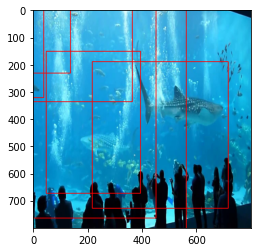

classification loss:  0.6915762424468994
regression loss: 20.506545925848357
10


Exception ignored in: <function tqdm.__del__ at 0x7f589dd954d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


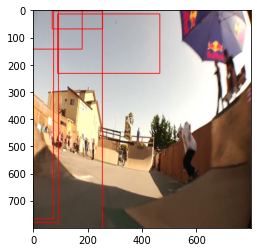

classification loss:  0.6937363256107677
regression loss: 9.525431096001245
10


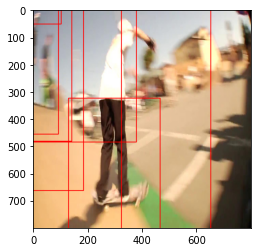

classification loss:  0.6938672264417013
regression loss: 7.644172282252963
10


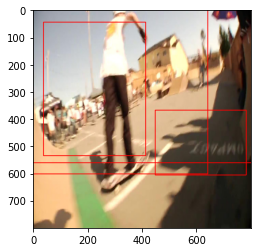

classification loss:  0.6936726454765566
regression loss: 8.384825504232397
10


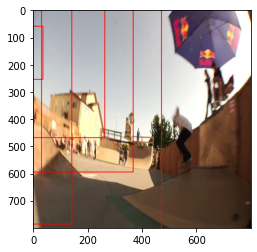

classification loss:  0.6937505471997145
regression loss: 9.44316953679726


KeyboardInterrupt: ignored

In [291]:
regression_loss_acc = []
classification_loss_acc = []

for iteration, (image_path, image, cls, loc)  in enumerate(tqdm(train_loader)):
  # image in shape of (1, 3, 800, 800)
  # cls in shape of (1, 22500, 1)
  # loc in shape of (1, 22500, 4)

  cls = cls[0].reshape(-1).to(device)
  loc = loc[0].to(device)
  image = image.to(device)
  
  optim.zero_grad()

  pred_cls, pred_loc = rpn(feature_extractor(image)) # output should be (1, 18, 50 , 50), (50 * 50 * 9 * 4, 4)

  pred_loc = pred_loc.contiguous().view(-1, 4)
  # pred_cls = pred_cls.permute(0, 2, 3, 1).contiguous().view(1, 50, 50, 18)
  # objectness_score = pred_cls.view(50 * 50, 9, 2)[:, :, :, 1].contiguous().view(-1, 1)
  pred_cls = pred_cls.view(-1, 2)

  # pred_cls.shape, pred_loc.shape, objectness_score.shape 
  

  classification_loss = F.cross_entropy(pred_cls, cls, ignore_index=-1)
  
  classification_loss_acc.append(classification_loss.item())
  # print(classification_loss.item())

  pos_index = torch.where(cls == 1)
  x = torch.abs(pred_loc[pos_index] - loc[pos_index])

  regression_loss = (x < 1).float() * (0.5) * (x**2) + (x > 1) * (x - 0.5)
  regression_loss = regression_loss.sum()
  regression_loss = regression_loss / (len(pos_index))

  regression_loss_acc.append(regression_loss.item())
  # print(regression_loss.item())

  regression_loss.backward()

  optim.step()

  if iteration % 10 == 0:
    
    # visualize 100 high score box
    obj_score = pred_cls[:, 1] # [22500, 2]
    
    order_index = obj_score.argsort(dim=0)[:2000]
    predicted_boxes = pred_loc[order_index].detach().cpu().numpy()
    for idx, pred_box in enumerate(predicted_boxes):
      anchor_box = anchor_boxes[order_index[idx]]
      predicted_boxes[idx] = parametrized_to_corner(*pred_box, anchor_box)


    detected_boxes = NMS(predicted_boxes) #[22500, 4]
    print(len(detected_boxes))
    # print(image_path)
    visualize(image_path[0], detected_boxes)

    print("classification loss: ", np.mean(classification_loss_acc[-100:]))
    print("regression loss:", np.mean(regression_loss_acc[-100:]))

## Post Process

$$ t_x = \frac{A_x - G_x}{A_w} $$
\
$$ t_w = \log{\frac{G_w}{A_w}} $$

In [ ]:
pred_location_convert.shape

(22500, 4)

In [ ]:
import numpy as np

In [ ]:
pred_loc = pred_loc[0]
# pred_location_convert = np.zeros_like(pred_loc)

In [ ]:
# from tqdm.auto import tqdm

# for idx, pred in enumerate(tqdm(pred_loc)):
#   A_x, A_y, A_w, A_h = corner2center(anchor_boxes[idx])
#   t_x, t_y, t_w, t_h = pred

#   x = A_x - (t_x * A_w)
#   y = A_y - (t_y * A_y)
#   w = np.exp(t_w) * A_w
#   h = np.exp(t_h) * A_h

#   x1, y1, x2, y2 = center2corner([x, y, w, h])
#   pred_location_convert[idx] = [x1, y1, x2, y2]


## Clip to the Image

## Filter Region Size

## Sort Scores

In [ ]:
order = objectness_score.ravel().argsort(descending=True)

pred_ordered = pred_location_convert[order[:12000], :]
pred_ordered.shape

(12000, 4)

## NMS

In [290]:
import numpy as np
from tqdm.auto import tqdm

def NMS(boxes):
  # boxes in order of the objectness score
  boxes_detected = []
  boxes_remained = np.copy(boxes)

  while len(boxes_remained) > 0:
    
    box_detected = boxes_remained[0]
    boxes_detected.append(box_detected)
    
    boxes_remained = boxes_remained[1:]

    mask = np.ones(len(boxes_remained), dtype=bool)
    idx_to_remove = []
    
    for idx, box in enumerate(boxes_remained):
      
      if compute_iou(box_detected, box) > 0.7:
        idx_to_remove.append(idx)
    
    boxes_remained = boxes_remained[mask, ...]
  
  return boxes_detected[:10]

In [ ]:
# NMS(pred_ordered)

## Preparation for Faster R-CNN

## Sampling ROIs

In [ ]:
ROI = np.random.rand(2000, 4)

In [ ]:
anchors_iou = get_anchors_iou("/content/image.jpg", "/content/label.png", ROI) # (number of anchors, number of gt boxes)

In [ ]:
max_iou = np.max(anchors_iou, axis=-1)

pos_labels = np.where(max_iou > 0.5)[0]

neg_labels = np.where((max_iou > 0.1) & (max_iou < 0.5))[0]

In [ ]:
positive_labels = np.random.choice(pos_labels, size=min(len(pos_labels), 32), replace=False)
negative_labels = np.random.choice(neg_labels, size=min(len(neg_labels), 96), replace=False)

In [ ]:
sample_index = np.append(positive_labels, negative_labels)
labels = np.zeros(128)
labels[:32] = 1

ROI_labels = labels   
sample_ROI = ROI[sample_index] 

In [ ]:
sample_ROI.shape, ROI_labels.shape

((0, 4), (128,))

## Converting

In [ ]:
anchor_gt = np.argmax(anchors_iou, axis=-1) # (2000)
gt_boxes = get_bounding_box("/content/image.jpg", "/content/label.png")

In [ ]:
gt_boxes = gt_boxes[anchor_gt[sample_index]]

In [ ]:
# (128, 4) in format x1, y1, x2, y2 
# we want t_x, t_y, t_w, t_h
gt_roi_locs = np.zeros_like(sample_ROI)

for i, roi in enumerate(sample_ROI):
  gt_roi_locs[i] = get_location(corner2center(roi), corner2center(gt_boxes[i]))

In [ ]:
image_index = torch.zeros((len(sample_ROI), 1))
rois = torch.from_numpy(sample_ROI)
indices_and_rois = torch.cat((image_index, rois), dim=1)
indices_and_rois.shape

torch.Size([0, 5])

## Fast R-CNN

In [ ]:
feature_map = feature_extractor(torch.randn((1, 3, 800, 800)))
feature_map.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 50, 50])

In [ ]:
adaptive_max_pool = nn.AdaptiveMaxPool2d((7, 7))
# adaptive_max_pool(torch.randn(1, 512, 50, 50)).shape

In [ ]:
output = []

for idx, roi in enumerate(indices_and_rois):
  
  image_index, x1, y1, x2, y2 = roi

  x1, y1, x2, y2 = x1 / 16, x2 / 16, y1 / 16, y2 / 16
  
  im = feature_map.narrow(0, 0, 1)[..., y1:y2, x1:x2]

  output.append(adaptive_max_pool(im))


# output = torch.cat(output, 0)
# print(output.shape)

# output = output.view(128, -1)

# Head Classifier and 

In [ ]:
roi_head_classifier = nn.Sequential(
    nn.Linear(255088, 4096),
    nn.Linear(4096, 4096)
)

cls_loc = nn.Linear(4096, 21 * 4)
score = nn.Linear(4096, 21)